In [1]:
import numpy as np
import dask.array as da
import xarray as xr
from sklearn_xarray import wrap, Target
from sklearn_xarray.preprocessing import Splitter, Sanitizer, Featurizer
from sklearn_xarray.model_selection import CrossValidatorWrapper
from sklearn_xarray.datasets import load_wisdm_dataarray
from sklearn.preprocessing import StandardScaler, LabelEncoder,LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
import sys
sys.path.append('/home/mmann1123/Documents/github/xr_fresh/')
from xr_fresh.transformers import Stackerizer 


nrows = 100
ncols = 200
row_chunks = 50
col_chunks = 50

data = da.random.random(size=(1, nrows, ncols), chunks=(1, row_chunks, col_chunks))

def create_band(data, x, y, band_name):

    return xr.DataArray(data,
                        dims=('band', 'y', 'x'),
                        coords={'band': [band_name],
                                'y': y,
                                'x': x})

def create_coords(data, left, top, celly, cellx):
    nrows = data.shape[-2]
    ncols = data.shape[-1]
    right = left + cellx*ncols
    bottom = top - celly*nrows
    x = np.linspace(left, right, ncols) + cellx/2.0
    y = np.linspace(top, bottom, nrows) - celly/2.0
    
    return x, y

x, y = create_coords(data, 1000, 2000, 30, 30)

src = []

for time in ['t1', 't2', 't3']:

    src_t = xr.concat([create_band(data, x, y, band) for band in ['blue', 'green', 'red', 'nir']], dim='band')\
                    .expand_dims(dim='time')\
                    .assign_coords({'time': [time]})
    
    src.append(src_t)

src = xr.concat(src, dim='time')
print(src)

<xarray.DataArray 'random_sample-a19895ecc83ce43974cb069a42d58a48' (time: 3, band: 4, y: 100, x: 200)>
dask.array<concatenate, shape=(3, 4, 100, 200), dtype=float64, chunksize=(1, 1, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) object 'blue' 'green' 'red' 'nir'
  * y        (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * x        (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * time     (time) object 't1' 't2' 't3'


In [2]:

land_use = np.tile( "water", (src.sizes["time"], src.sizes["y"], src.sizes["x"]) ).astype(object)
land_use[src.sel(band='green').values > 0.5] = "forest"
land_use = land_use.astype(str)
src.coords["land_use"] = (["time", "y", "x"], land_use)

X = Stackerizer(stack_dims = ('x','y','time'), direction='stack').fit_transform(src)

print(X)
print('----------------------')
print(X.values)
print(X.land_use.values)

print('----------------------')
print(X.shape)
print(X.land_use.shape)

<xarray.DataArray 'random_sample-a19895ecc83ce43974cb069a42d58a48' (sample: 60000, band: 4)>
dask.array<transpose, shape=(60000, 4), dtype=float64, chunksize=(3000, 1), chunktype=numpy.ndarray>
Coordinates:
  * band      (band) object 'blue' 'green' 'red' 'nir'
    land_use  (sample) <U6 'water' 'water' 'water' ... 'water' 'water' 'water'
  * sample    (sample) MultiIndex
  - x         (sample) float64 1.015e+03 1.015e+03 ... 7.015e+03 7.015e+03
  - y         (sample) float64 1.985e+03 1.985e+03 ... -1.015e+03 -1.015e+03
  - time      (sample) object 't1' 't2' 't3' 't1' 't2' ... 't3' 't1' 't2' 't3'
----------------------
[[0.27828509 0.27828509 0.27828509 0.27828509]
 [0.27828509 0.27828509 0.27828509 0.27828509]
 [0.27828509 0.27828509 0.27828509 0.27828509]
 ...
 [0.14799641 0.14799641 0.14799641 0.14799641]
 [0.14799641 0.14799641 0.14799641 0.14799641]
 [0.14799641 0.14799641 0.14799641 0.14799641]]
['water' 'water' 'water' ... 'water' 'water' 'water']
----------------------
(60000

In [3]:
pl = Pipeline(
    [  
       ("sanitizer", Sanitizer()),    # Remove elements containing NaNs.
       ("featurizer", Featurizer()),  # Stack all dimensions and variables except for sample dimension.
       ("scaler", wrap(StandardScaler)), # zscores , ?wrap if xarray.self required? 
       ("pca", wrap(PCA, reshapes="feature")), 
       ("cls", wrap(GaussianNB, reshapes="feature")),
    ]
)

##############################################################################
# Since we want to use cross-validated grid search to find the best model
# parameters, we define a cross-validator. In order to make sure the model
# performs subject-independent recognition, we use a `GroupShuffleSplit`
# cross-validator that ensures that the same subject will not appear in both
# training and validation set.

cv = CrossValidatorWrapper(
    GroupShuffleSplit(n_splits=3, test_size=0.5), groupby=["time"]
)

##############################################################################
# The grid search will try different numbers of PCA components to find the best
# parameters for this task.

gs = GridSearchCV(
    pl, cv=cv, n_jobs=-1, verbose=1, param_grid={"pca__n_components": [5,10]}
)

##############################################################################
# The label to classify is the activity which we convert to an integer
# representation for the classification.

y = Target(
    coord="land_use", transform_func=LabelEncoder().fit_transform )(X)

##############################################################################
# Finally, we run the grid search and print out the best parameter combination.

gs.fit(X, y)
print("Best parameters: {0}".format(gs.best_params_))
print("Accuracy: {0}".format(gs.best_score_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    4.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.8s finished


Best parameters: {'pca__n_components': 5}
Accuracy: 0.99965


/home/mmann1123/anaconda3/envs/sk-wombat/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


/home/mmann1123/anaconda3/envs/sk-wombat/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


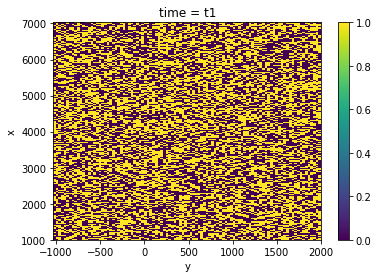

In [4]:
#%% predict 
yp = gs.predict(X)
yp = yp.unstack("sample")
yp.sel(time='t1').plot.imshow()
 

In [6]:
#%% predict labels
yp = gs.predict(X)
yp.values = LabelEncoder().fit(X.land_use).classes_[yp]
yp = yp.unstack("sample")
print(yp)


<xarray.DataArray (x: 200, y: 100, time: 3)>
array([[['water', 'water', 'water'],
        ['water', 'water', 'water'],
        ['forest', 'forest', 'forest'],
        ...,
        ['water', 'water', 'water'],
        ['forest', 'forest', 'forest'],
        ['forest', 'forest', 'forest']],

       [['water', 'water', 'water'],
        ['forest', 'forest', 'forest'],
        ['water', 'water', 'water'],
        ...,
        ['water', 'water', 'water'],
        ['water', 'water', 'water'],
        ['forest', 'forest', 'forest']],

       [['forest', 'forest', 'forest'],
        ['forest', 'forest', 'forest'],
        ['water', 'water', 'water'],
        ...,
...
        ...,
        ['forest', 'forest', 'forest'],
        ['water', 'water', 'water'],
        ['forest', 'forest', 'forest']],

       [['forest', 'forest', 'forest'],
        ['forest', 'forest', 'forest'],
        ['water', 'water', 'water'],
        ...,
        ['forest', 'forest', 'forest'],
        ['water', 'water', 'wa

/home/mmann1123/anaconda3/envs/sk-wombat/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
